# Nanoparticle & Surface Strain

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from psm.segments import Segments
from psm.build import lattice_segment
from psm import plotutils

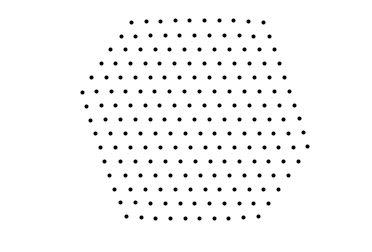

In [3]:
points = np.load('data/nanoparticle.npy')
plt.plot(points[:,0],points[:,1],'k.')
plt.axis('equal')
plt.axis('off')

plt.savefig('nanoparticle_points.pdf')

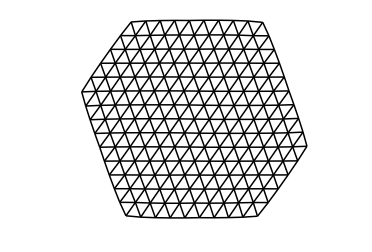

In [4]:
points = np.load('data/nanoparticle.npy')

segments = Segments(points)
segments.build_graph(.5)
segments.show_edges()
plt.axis('off')

plt.savefig('nanoparticle_graph.pdf')

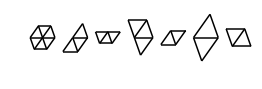

In [5]:
a = [1, 0]
b = [1/3., -2*np.sqrt(2)/3.]

templates = lattice_segment(a, b, max_depth=2)

templates = templates[0].detach()
templates.extend(templates[0].detach([0,1,2,3,4]))
templates.extend(templates[0].detach([0,2,3,4,5]))
templates.extend(templates[0].detach([0,1,2,3,6]))
templates.extend(templates[0].detach([0,1,5,6]))
templates.extend(templates[0].detach([0,4,5,6]))
templates.extend(templates[0].detach([0,1,2,6]))

fig,axes=plt.subplots(1,7,figsize=(4,1))

templates.show(7, nrows=1, show_order=False, axes=axes);
for ax in axes:
    ax.axis('off')

plt.savefig('nanoparticle_templates.pdf')

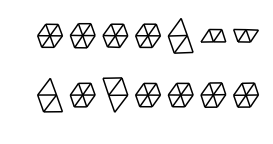

In [7]:
fig,axes=plt.subplots(2,7,figsize=(4,2))

segments.traversals(max_depth=2)
segments.show(14, nrows=2, sample=True, axes=axes);

for ax in axes:
    for ax in ax:
        ax.axis('off')

plt.savefig('nanoparticle_segments.pdf')

In [8]:
rmsd = segments.register(templates, transform='similarity', pivot='front')

 [||||||||||||||||||||] 1365/1365 registrations


In [9]:
ax, p = plotutils.voronoi_plot(segments, labels=best_match, cmap=plt.cm.Dark2.colors, legend=False)

ax.axis('equal')
ax.axis('off')
plt.savefig('nanoparticle_labels.pdf')

NameError: name 'best_match' is not defined

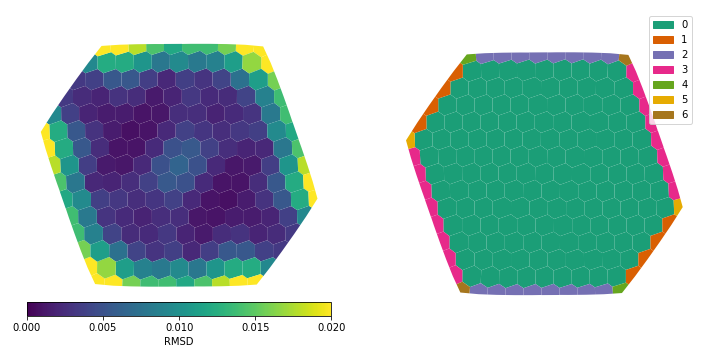

In [11]:
best_match, best_rmsd = segments.best_matches()

fig,axes = plt.subplots(1,2,figsize=(12,6))

_, p = plotutils.voronoi_plot(segments, axes[0], c=best_rmsd, cmap='viridis', vmin=0, vmax=.02)
plotutils.add_colorbar(axes[0], label='RMSD', cmap='viridis', vmin=0, vmax=.02)

_, p = plotutils.voronoi_plot(segments, axes[1], labels=best_match, cmap=plt.cm.Dark2.colors)

for ax in axes.ravel():
    ax.axis('equal')
    ax.axis('off')

In [15]:
unique, counts = np.unique(best_match, return_counts=True)

print('Bulk:\t\t', counts[0])
print('<100>-facet:\t', counts[1])
print('<110>-facet:\t', counts[2]+counts[3])
print('Corner:\t\t', counts[4]+counts[5]+counts[6])

Bulk:		 149
<100>-facet:	 8
<110>-facet:	 32
Corner:		 6


In [16]:
strain, rotation = segments.calc_strain(adjust_zero='median')

planar = np.trace(strain, axis1=1, axis2=2) / 2

rotation = (rotation - np.pi/2) % np.pi - np.pi/2

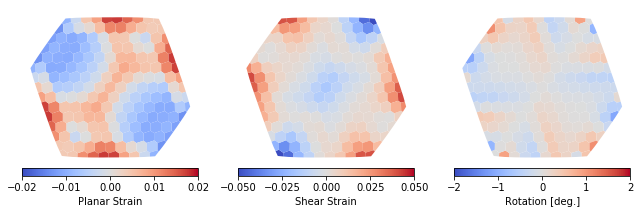

In [17]:
fig,axes = plt.subplots(1,3,figsize=(9,4))

plotutils.voronoi_plot(segments, axes[0], c=planar, cmap='coolwarm', vmin=-.02, vmax=.02)
plotutils.add_colorbar(axes[0], label='Planar Strain', cmap='coolwarm', vmin=-.02, vmax=.02)

plotutils.voronoi_plot(segments, axes[1], c=strain[:,0,1], cmap='coolwarm', vmin=-.05, vmax=.05)
plotutils.add_colorbar(axes[1], label='Shear Strain', cmap='coolwarm', vmin=-.05, vmax=.05)

plotutils.voronoi_plot(segments, axes[2], c=rotation / np.pi * 180, cmap='coolwarm', vmin=-2, vmax=2)
plotutils.add_colorbar(axes[2], label='Rotation [deg.]', cmap='coolwarm', vmin=-2, vmax=2)

for ax in axes:
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')

plt.tight_layout()

plt.savefig('nanoparticle_strain.pdf')

In [10]:
from psm.geometry import transform

def reorient_strains(strain, labels, rotation, surface_directions):
    
    strain = strain.copy()
    for label in np.unique(labels):
        if label in surface_directions.keys():
            angles = surface_directions[label] - rotation[labels==label]
            
            strain[labels==label] = transform.rotate_strain(strain[labels==label], angles)
            
    return strain

In [11]:
surface = np.isin(best_match, [1,2,3])

surface_directions = {1: -np.arctan((a[0]+b[0]) / (a[1]+b[1])), 
                      2: 0,
                      3: np.arctan(b[1]/b[0])}

rotated_strain = reorient_strains(strain, best_match, rotation, surface_directions)

In [12]:
print('Average surface relaxations')
print('<100>: {:.3f} %'.format(np.mean(rotated_strain[best_match==1,1,1])*100))
print('<110>: {:.3f} %'.format(np.mean(rotated_strain[np.isin(best_match,[2,3]),1,1])*100))

Average surface relaxations
<100>: -2.082 %
<110>: 3.442 %
